In [13]:
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
import pandas as pd

In [14]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.hidden_layer = nn.Linear(3, 100)
        self.output_layer = nn.Linear(100, 3)
        self.activation_function = nn.Tanh()

    def forward(self, x):
        x = self.activation_function(self.hidden_layer(x))
        x = self.output_layer(x)
        return x


def training_loop(training_dataloader, model, optimizer, mse, device):
    # accumulated the loss
    acc_loss = 0

    for i, (inputs, targets) in enumerate(training_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = mse(outputs, targets)
        loss.backward()

        # adjust learning weights
        optimizer.step()

        acc_loss += loss.item()
        print(f'  batch {i + 1} loss: {loss.item()}')
        
    avg_loss = acc_loss / len(training_dataloader)
    print(f'  average loss (training): {avg_loss}')

    return avg_loss

def test_loop(testing_dataloader, model, mse, device):
    model.eval()
    
    acc_loss = 0

    for i, (inputs, targets) in enumerate(testing_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        loss = mse(outputs, targets)
        acc_loss += loss.item()

    avg_loss = acc_loss / len(testing_dataloader)
    print(f'  average loss (testing): {avg_loss}')

    model.train()

    return avg_loss


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel()
model.to(device)

#-------------------------------------------
# Loading the data using pandas
#-------------------------------------------
path = '../../datasets/joint_positions_data_1000.csv'
df = pd.read_csv(path)
X = df[['x', 'y', 'pitch']].to_numpy()
y = df[['shoulder', 'elbow', 'wrist']].to_numpy()

# ----------------------------------------------------------
# splitting the data into training, validation and test sets
# ----------------------------------------------------------
test_size = 0.3
batch_size = 32

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=42
)

# transforming data into tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32)

# sending data to the GPU
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor  = X_test_tensor.to(device)
y_test_tensor  = y_test_tensor.to(device)

training_dataset = TensorDataset(X_train_tensor, y_train_tensor)
testing_dataset = TensorDataset(X_test_tensor, y_test_tensor)

training_dataloader = DataLoader(
    training_dataset,
    batch_size=batch_size,
    shuffle=True
)
testing_dataloader = DataLoader(
    testing_dataset,
    batch_size=batch_size,
    shuffle=True
)


mse = nn.MSELoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.001,
    weight_decay=0.0001
)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50

avg_training_losses = []
avg_testing_losses = []

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}')
    model.train(True)
    avg_loss = training_loop(
        training_dataloader,
        model,
        optimizer,
        mse,
        device
    )
    avg_training_losses.append(avg_loss)
    avg_testing_loss = test_loop(
        testing_dataloader,
        model,
        mse,
        device
    )
    avg_testing_losses.append(avg_testing_loss)

Epoch: 1
  batch 1 loss: 1.2693177461624146
  batch 2 loss: 1.4343299865722656
  batch 3 loss: 1.333913803100586
  batch 4 loss: 1.2870771884918213
  batch 5 loss: 1.232488989830017
  batch 6 loss: 1.2968734502792358
  batch 7 loss: 1.4423365592956543
  batch 8 loss: 1.3742674589157104
  batch 9 loss: 1.1185845136642456
  batch 10 loss: 1.2207529544830322
  batch 11 loss: 1.3601298332214355
  batch 12 loss: 1.3762900829315186
  batch 13 loss: 1.3709321022033691
  batch 14 loss: 1.2930312156677246
  batch 15 loss: 1.2562764883041382
  batch 16 loss: 1.1529545783996582
  batch 17 loss: 1.2753534317016602
  batch 18 loss: 1.1192758083343506
  batch 19 loss: 1.1507526636123657
  batch 20 loss: 1.2589675188064575
  batch 21 loss: 1.2698514461517334
  batch 22 loss: 1.3519654273986816
  average loss (training): 1.2838965112512761
  average loss (testing): 1.3710569620132447
Epoch: 2
  batch 1 loss: 1.1151173114776611
  batch 2 loss: 1.3963197469711304
  batch 3 loss: 1.336992621421814
  batc

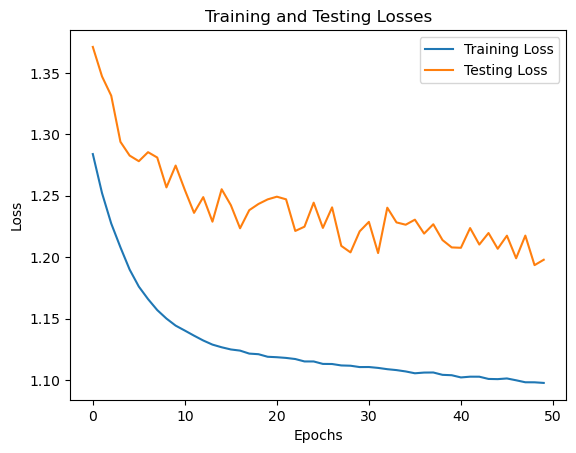

In [16]:
# Plotting the training and testing losses over epochs
import matplotlib.pyplot as plt
plt.plot(avg_training_losses, label='Training Loss')
plt.plot(avg_testing_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()